<a href="https://colab.research.google.com/github/LeeYoungWook/dd/blob/master/%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **오토인코더**

오토인코더 : 오토엔코더는 입력데이터를  집어넣어서 나오는 출력이 입력데이터의 근사를 갖는 비지도 학습이다.


![대체 텍스트](https://github.com/LeeYoungWook/dd/blob/master/%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.PNG?raw=true)

-인코더: 입력 데이터를 표현할 수 있는 핵심 특징으로 압축시킨다. 

-디코더: 인코더에서 압축된 핵심 특징을 다시 디코더 부분에서 입력 데이터와 동일하게 복원시킨다.






In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [2]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [0]:

# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [0]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


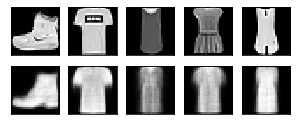

[Epoch 2]


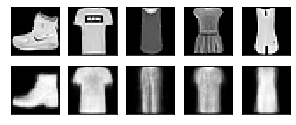

[Epoch 3]


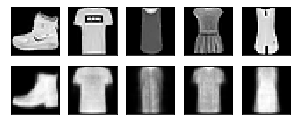

[Epoch 4]


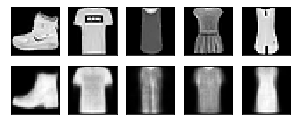

[Epoch 5]


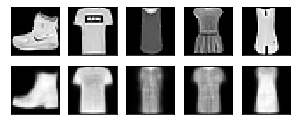

[Epoch 6]


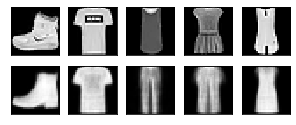

[Epoch 7]


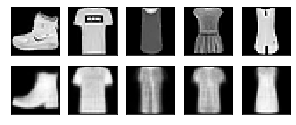

[Epoch 8]


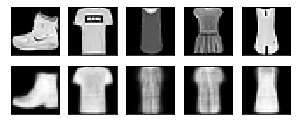

[Epoch 9]


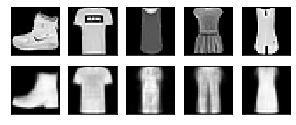

[Epoch 10]


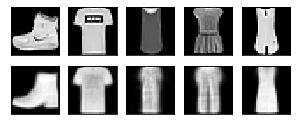

In [6]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기 (두번째 열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

In [0]:
from torchsummary import summary


**잠재변수 들여다보기**

In [0]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

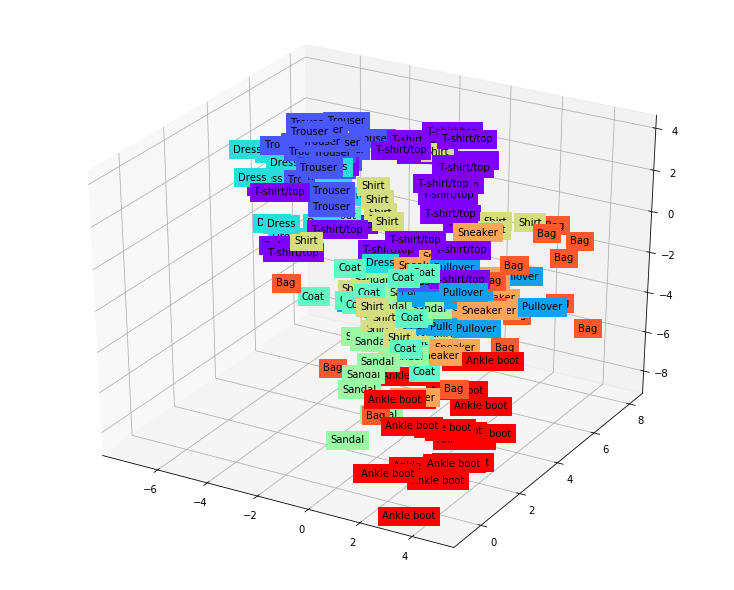

In [8]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

# **잡음 제거 오토인코더**

In [0]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np

In [19]:
# 하이퍼파라미터
EPOCH = 30
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


In [0]:
# Fashion MNIST 학습 데이터셋
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [0]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [0]:

def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [0]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x)  # 입력에 노이즈 더하기
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [25]:

for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

[Epoch 1] loss:0.07531510907481474
[Epoch 2] loss:0.06562361940106096
[Epoch 3] loss:0.06438774733083334
[Epoch 4] loss:0.06367817563590591
[Epoch 5] loss:0.06324676438959549
[Epoch 6] loss:0.06299486056144939
[Epoch 7] loss:0.06262633564677447
[Epoch 8] loss:0.06241918574057535
[Epoch 9] loss:0.06222409315343732
[Epoch 10] loss:0.062039538125779586
[Epoch 11] loss:0.06195454152106349
[Epoch 12] loss:0.061901505142926916
[Epoch 13] loss:0.061806070223164714
[Epoch 14] loss:0.06178561046020563
[Epoch 15] loss:0.06168318298389154
[Epoch 16] loss:0.06175419318872982
[Epoch 17] loss:0.06161429868069793
[Epoch 18] loss:0.06152855036164652
[Epoch 19] loss:0.06154919323175828
[Epoch 20] loss:0.06182980916695173
[Epoch 21] loss:0.061527317715510885
[Epoch 22] loss:0.06137665698745612
[Epoch 23] loss:0.06148972228836658
[Epoch 24] loss:0.06138245330484056
[Epoch 25] loss:0.06136240050800319
[Epoch 26] loss:0.06148958832883377
[Epoch 27] loss:0.06134672215117066
[Epoch 28] loss:0.061309131291279


**이미지 복원 시각화 하기**

In [0]:
# 모델이 학습시 본적이 없는 데이터로 검증하기 위해 테스트 데이터셋을 가져옵니다.
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

# 테스트셋에서 이미지 한장을 가져옵니다.
sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

# 이미지를 add_noise로 오염시킨 후, 모델에 통과시킵니다.
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

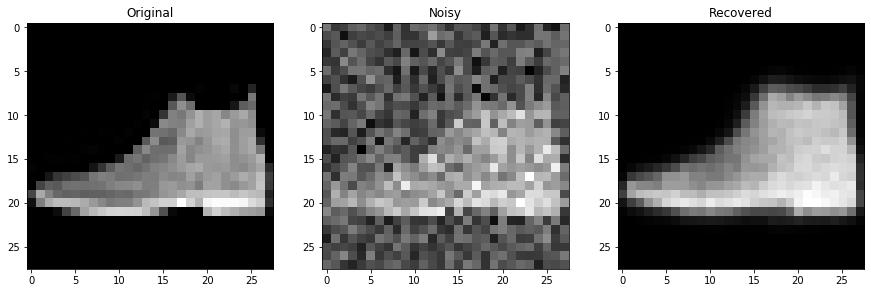

In [29]:

f, a = plt.subplots(1, 3, figsize=(15, 15))

# 시각화를 위해 넘파이 행렬로 바꿔줍니다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()